In [ ]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import seaborn
import seaborn as sns

Ws = joblib.load('logBSC_H200_W.pkl')
separability = joblib.load('separability.pkl')
mean_Ws = np.mean(Ws, axis=(1,2))
db = joblib.load('db_dict.pkl')
db = np.array([db[str(i)][1] for i in range(3539)])

def get_seps(features, separability, excl_idx=None):
    features = np.reshape(features, (60, 200))
    separabilities_sample = []
    for ft in features:
        if ft.any():
            if excl_idx is not None:
                separabilities_sample.append(np.array([separability[loc] for loc in np.where(ft)[0] if not np.isin(loc, excl_idx)]))
            else:
                separabilities_sample.append(separability[np.where(ft)[0]])
    return np.concatenate(separabilities_sample)

plt.style.use('mb')

pos_sep_bool = np.logical_and(separability>0.9, mean_Ws>0.18)
neg_sep_bool = np.logical_and(separability>0.9, mean_Ws<-0.18)
sign_split_pos = mean_Ws > 0.0
sign_split_neg = mean_Ws < 0.0
excl_ind_gen_pos = np.where(sign_split_pos)
excl_ind_gen_neg = np.where(sign_split_neg)
excl_indices_neg = np.where(neg_sep_bool)[0]
excl_indices = np.concatenate([np.where(pos_sep_bool)[0], np.where(neg_sep_bool)[0]])

bscs = joblib.load('../semisupervised/logBSC_H200_stimuli.pkl')
bscs = np.reshape(bscs, (3539, -1, 200))
sep_without_db = []

BFs = []
BFs_wdb = []
for k in range(3539):
    seps = []
    seps_wdb = []
    for i in range(60):
        if bscs[k,i].any():
            loc_idx = np.where(bscs[k,i])[0]
            seps.append(np.mean([separability[loc] for loc in loc_idx]))
            if not np.isin(loc_idx, excl_indices).all():
                seps_wdb.append(np.mean([separability[loc] for loc in loc_idx if loc not in excl_indices]))
    BFs.append(np.mean(seps))
    BFs_wdb.append(seps_wdb)

sep_mean = np.array(BFs)
sep_mean_no_db = [np.mean(bl) if bl else np.nan for bl in BFs_wdb]
sep_mean_no_bn = np.array(sep_mean_no_db)
args_sep = np.argsort(separability)

ratings = pd.read_csv('subj_3_to_20_RMSE_WADA_NIST.csv')
ratings = ratings.values[:,:-3]
ratings_idx = ratings[:,0].astype('int')
ratings = ratings[:,1:]
mean_ratings = ratings.mean(axis=1)
median_ratings = np.median(ratings, axis=1)

#stims = {'SNR {} db'.format({'':0, '_10':10,'_20':20, '_n5':-5}[i]) : joblib.load('noisy_fg{}.pkl'.format(i)) for i in ['','_10','_20', '_n5']}
stims = {'SNR {} db'.format(i) : joblib.load('speech_noise_{}db.pkl'.format(i))  for i in [-10,-5,0,5,10]}
seps_stim = { lbl : np.concatenate([get_seps(ft, separability) for ft in features]) for lbl, features in stims.iteritems()}
seps_stim_pos = { lbl : np.concatenate([get_seps(ft, separability, excl_ind_gen_neg) for ft in features]) for lbl, features in stims.iteritems()}
seps_stim_neg = { lbl : np.concatenate([get_seps(ft, separability, excl_ind_gen_pos) for ft in features]) for lbl, features in stims.iteritems()}
seps_mean_stim = { lbl : np.array([get_seps(ft, separability).mean() for ft in features]) for lbl, features in stims.iteritems()}

bsc_counts = np.reshape(bscs, (-1,60,200)).sum(axis=(0,1))
seps_stim_counts = {lbl : np.reshape(stm, (-1,60,200)).sum(axis=(0,1)) for lbl, stm in stims.iteritems()}
bsc_counts = bsc_counts / bsc_counts.sum()
seps_stim_counts = {lbl:ft/ft.sum() for lbl, ft in seps_stim_counts.iteritems()}

pcs = joblib.load('pcs.pkl').mean(axis=0)[:,:3]
sep_2 = joblib.load('sep_of_pos_Ws_only.pkl')
average_W = joblib.load('average_Ws_per_segment.pkl')
pcs[:,0] *= -1
pcs[:,1] *= -1

speech_overlap = joblib.load('speech_overlap.pkl')
mps_orig = joblib.load('MPS_orig.pkl')
mps_orig_reshaped = np.reshape(mps_orig, (200, -1))
coefs = np.reshape(np.reshape(joblib.load('coefs_bla.pkl').T, (-1,5,200))[:,:3], (-1, 200)).T

cluster_means = joblib.load('cluster_means.pkl')

/home/mboos/anaconda2/lib/python2.7/site-packages/matplotlib/style/core.py:201: UserWarning: In /home/mboos/.config/matplotlib/stylelib/mb.mplstyle: Bad val "white" on line #20
	"grid.linewidth: white
"
	in file "/home/mboos/.config/matplotlib/stylelib/mb.mplstyle"
	Key grid.linewidth: Could not convert "white" to float
  warnings.warn(message)


In [ ]:
cluster_means = joblib.load('cluster_means.pkl')

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(method='modified', n_neighbors=35, n_components=2, random_state=100)
emb_Ws = lle.fit_transform(np.reshape(Ws,(200,-1)))

In [69]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=10, learning_rate=50, init='pca', n_iter=5000)
emb_Ws2 = tsne.fit_transform(np.reshape(Ws,(200,-1)))
#joblib.dump(emb_Ws2, 'bla.pkl')

In [3]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=10, learning_rate=50, init='pca', n_iter=5000)
emb_coefs = tsne.fit_transform(coefs)

/home/mboos/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


In [6]:
joblib.dump(emb_coefs, 'component_tsne_coefs.pkl')

['component_tsne_coefs.pkl']

In [2]:
bscs = joblib.load('../semisupervised/logBSC_H200_stimuli.pkl')
bscs = np.reshape(bscs, (3539, -1, 200))
summed_bscs = bscs.sum(axis=1)
speech_overlap = joblib.load('speech_overlap.pkl')
contains_speech = speech_overlap > 5.5
contains_less_speech = speech_overlap < 5.0
corr_speech_BF = np.array([np.corrcoef(summed_bscs[:,i], speech_overlap)[0,1] for i in range(200)])
sensitivity_to_speech = summed_bscs[contains_speech].sum(axis=0) / summed_bscs[contains_less_speech].sum(axis=0)

In [2]:
reshaped_coefs = np.reshape(coefs.T, (-1,3,200)).mean(axis=0).T

In [20]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
coefs_scaled = scaler.fit_transform(coefs)
gmm = GaussianMixture(n_components=5)
tr_coefs = gmm.fit_predict(coefs)

In [7]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import kneighbors_graph
scaler = StandardScaler()
coefs_scaled = scaler.fit_transform(coefs)
knngraph = kneighbors_graph(coefs_scaled, 5, include_self=False)
mmt = MinMaxScaler().fit_transform(mps_orig_reshaped.T).T
aggl = AgglomerativeClustering(n_clusters=10, linkage='ward').fit(mmt)

/home/mboos/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


In [13]:
Ws_reshaped = np.reshape(Ws, (200,-1))
mps_orig_reshaped = np.reshape(mps_orig, (200, -1))
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
gmm = BayesianGaussianMixture(n_components=5, max_iter=2000, init_params='random', weight_concentration_prior=1e-10, mean_precision_prior=0.8)
gmm = GaussianMixture(n_components=10, init_params='random')
mmt = MinMaxScaler().fit_transform(mps_orig_reshaped.T).T
predicted_Ws2 = gmm.fit_predict(mmt)

In [10]:
mean_Ws = Ws.mean(axis=(1,2))

In [13]:
import librosa as lbr
mel_filters = lbr.filters.mel(sr=44100, n_fft=882, fmax=8000, n_mels=48)
def get_mps(spec):
    return np.abs(np.fft.fftshift(np.fft.fft2(spec.dot(mel_filters))))

def get_mps_unchanged(spec):
    return np.abs(np.fft.fftshift(np.fft.fft2(spec)))

In [9]:
Ws_bla = Ws.dot(mel_filters)

In [14]:
mps_orig = np.concatenate([get_mps_unchanged(W)[None] for W in Ws], axis=0)

In [21]:
mps_orig_reshaped = np.reshape(mps_orig, (200,-1))

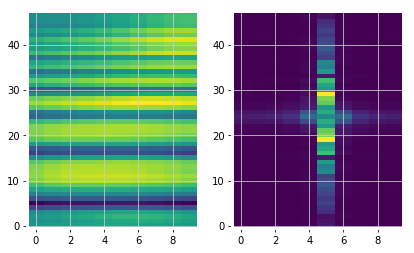

In [15]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(Ws[54].T, aspect='auto', origin='lower', cmap='viridis')
ax[1].imshow(mps_orig[54].T, aspect='auto', origin='lower', cmap='viridis')

In [8]:
MPS = np.concatenate([get_mps(W)[None] for W in Ws], axis=0)

In [4]:
np.unique(predicted_Ws2, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([27, 39, 18, 14, 15, 18, 12, 21, 17, 19]))

In [13]:
labels = aggl.labels_
vmax = max(Ws.max(), -Ws.min())
yspace = np.logspace(0, np.log10(8000), 48)
yticks = [2, 24, 47]
ytick_labels = ['1 Hz', '100 Hz', '8000 Hz']
xticks = [0, 5, 9]
xtick_labels = ['0 ms', '50 ms', '100 ms']
for i in range(len(np.unique(labels))):
    args = np.where(labels==i)[0]
    n_rows = np.ceil(len(args)/5).astype('int')
    if n_rows > 10:
        args_1, args = np.array_split(args, 2)
        n_rows = int(n_rows / 2)+1
        fig, axes = plt.subplots(n_rows, 5, figsize=(20,3*n_rows), constrained_layout = True)
        axes_flat = axes.flatten()
        if n_rows==1:
            axes = axes[None]
        for i_bf in range(len(args_1)):
            axes_flat[i_bf].imshow(Ws[args_1[i_bf]].T, vmax=vmax, vmin=-vmax, origin='lower', aspect='auto', cmap='bwr')
            axes_flat[i_bf].get_xaxis().set_visible(False)
            axes_flat[i_bf].get_yaxis().set_visible(False)
        for ax in axes[-1,:]:
            ax.get_xaxis().set_visible(True)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xtick_labels)
            ax.tick_params(axis='x', which='major', labelsize=25, labelrotation=30)
        for ax in axes[:,0]:
            ax.get_yaxis().set_visible(True)
            ax.set_yticks(yticks)
            ax.set_yticklabels(ytick_labels)
            ax.tick_params(axis='y', which='major', labelsize=25)
        fig.savefig('BF_MPS_agg_cluster_{}_split.png'.format(i+1))
    fig, axes = plt.subplots(n_rows, 5, figsize=(20,3*n_rows), constrained_layout = True)
    axes_flat = axes.flatten()
    if n_rows==1:
        axes = axes[None]
    for i_bf in range(len(args)):
        axes_flat[i_bf].imshow(Ws[args[i_bf]].T, vmax=vmax, vmin=-vmax, origin='lower', aspect='auto', cmap='bwr')
        axes_flat[i_bf].get_xaxis().set_visible(False)
        axes_flat[i_bf].get_yaxis().set_visible(False)
    for ax in axes[-1,:]:
        ax.get_xaxis().set_visible(True)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)
        ax.tick_params(axis='x', which='major', labelsize=25, labelrotation=30)
    for ax in axes[:,0]:
        ax.get_yaxis().set_visible(True)
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.tick_params(axis='y', which='major', labelsize=25)
    fig.savefig('BF_MPS_agg_cluster_{}.png'.format(i+1))
    plt.close()

In [14]:
joblib.dump(aggl.labels_, 'cluster_identity.pkl')

['cluster_identity.pkl']

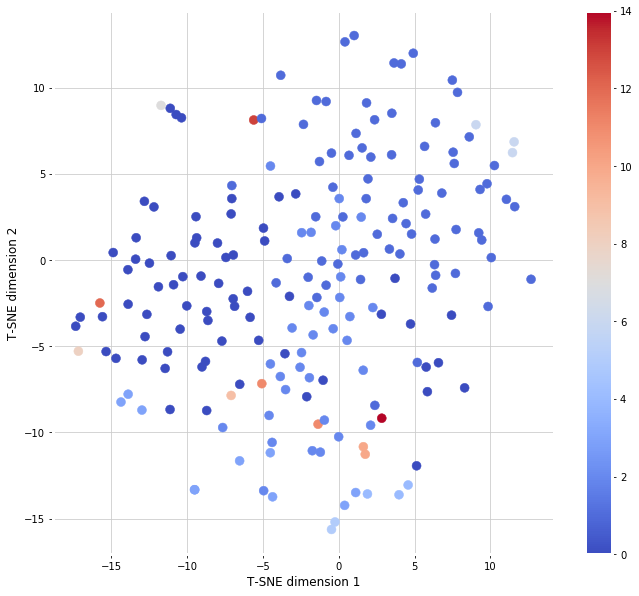

In [16]:
ig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.scatter(emb_coefs[:,0], emb_coefs[:,1], s=80, c=aggl.labels_, cmap='coolwarm')
plt.xlabel('T-SNE dimension 1')
plt.ylabel('T-SNE dimension 2')
cbar = plt.colorbar(im)

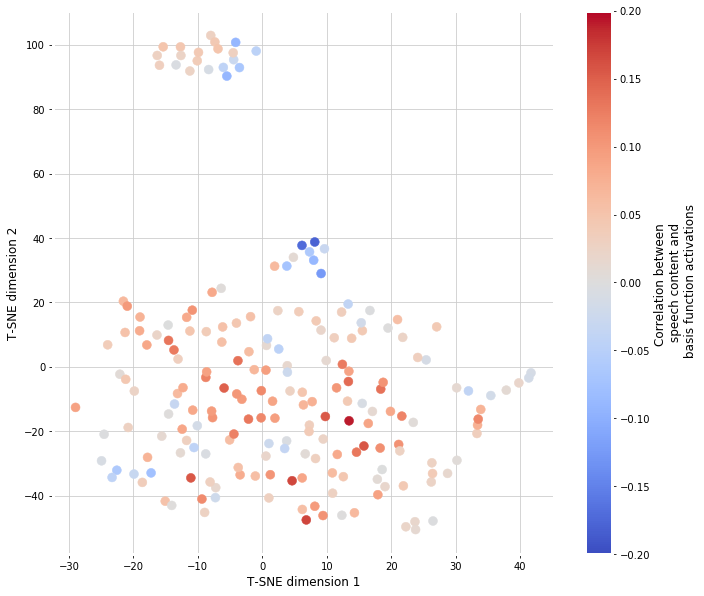

In [72]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.scatter(emb_Ws2[:,0], emb_Ws2[:,1], s=80, c=corr_speech_BF, vmin=-0.2, vmax=0.2, cmap='coolwarm')
plt.xlabel('T-SNE dimension 1')
plt.ylabel('T-SNE dimension 2')
cbar = plt.colorbar(im)
cbar.set_label('Correlation between \n speech content and \n basis function activations')
fig.savefig('TSNE_BF_Speech.svg')

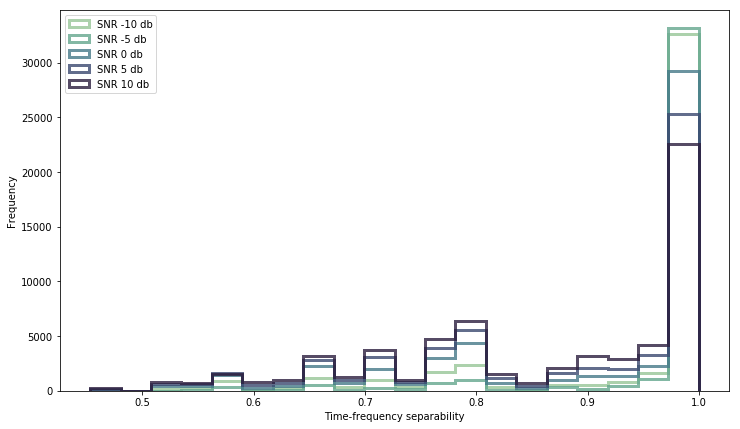

In [27]:
ratings_cmap = sns.cubehelix_palette(5, start=.5, light=.7, rot=-.75)
fig, ax = plt.subplots(1,1, figsize=(12,7))
for lbl, c in zip([-10,-5,0,5,10], ratings_cmap):
#    sns.kdeplot(seps_stim['SNR {}db'.format(lbl)], label='{} db'.format(lbl), ax=ax)
#    sns.distplot(seps_stim_neg['{} db'.format(lbl)], label='{} db'.format(lbl), ax=ax, kde=False, hist_kws={'histtype' : 'step', 'alpha' : 0.8, 'color':c, 'linestyle' : 'dashed', 'linewidth':3})
    sns.distplot(seps_stim['SNR {} db'.format(lbl)], bins=20, label='SNR {} db'.format(lbl), ax=ax, kde=False, hist_kws={'histtype' : 'step', 'alpha' : 0.8, 'color':c, 'linestyle' : 'solid', 'linewidth':3})
plt.legend(loc=2)
plt.xlabel('Time-frequency separability')
plt.ylabel('Frequency')
#plt.savefig('distribution_separability_artificial_noise.svg')

In [6]:
def make_barplot_df(dict_of_hists, edges):
    edge_names = np.array(['{} - {}'.format(edges[i], edges[i+1]) for i in range(len(edges)-1)])
    categories = np.concatenate([np.repeat(edge_names, dict_of_hists[label]) for label in [-10, -5, 0, 5, 10]])
    snr = np.repeat(np.array([-10,-5,0,5,10]), [dict_of_hists[label].sum() for label in [-10, -5, 0, 5, 10]])
    df = pd.DataFrame({'SNR' : snr, 'Separability range' : categories})
    return df    

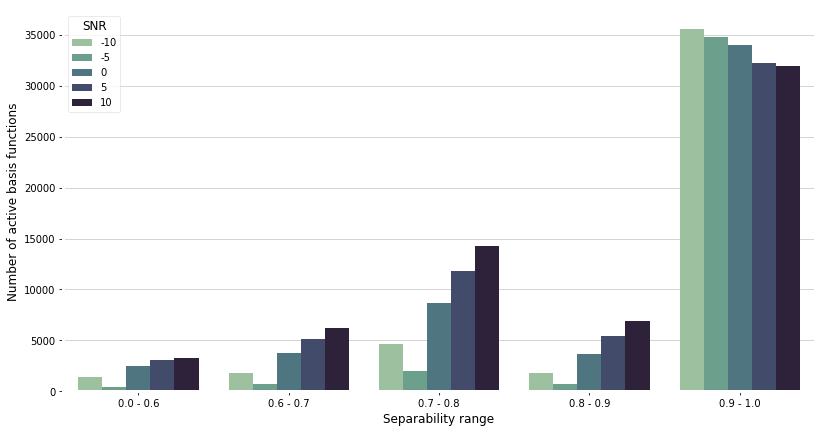

In [7]:
ratings_cmap = sns.cubehelix_palette(5, start=.5, light=.7, rot=-.75)
fig, ax = plt.subplots(1,1, figsize=(12,7))
edges = [0.,0.6,0.7,0.8,0.9,1.0]
hists = {lbl : np.histogram(seps_stim['SNR {} db'.format(lbl)], bins=edges)[0] for lbl in [-10,-5,0,5,10]}
df = make_barplot_df(hists, edges)
sns.countplot(x='Separability range', hue='SNR', data=df, palette=ratings_cmap)
plt.ylabel('Number of active basis functions')
plt.savefig('separability_range_barplot.svg')

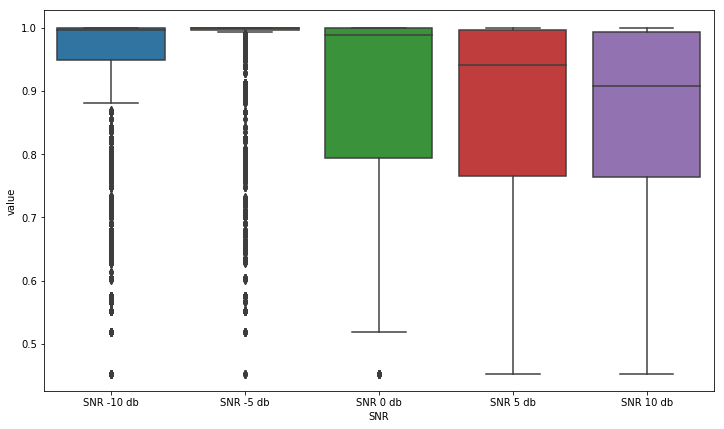

In [28]:
seps_df = pd.DataFrame({'SNR' : np.repeat(*zip(*[(snr, arr.shape[0]) for snr, arr in seps_stim.items()])), 'value' : np.concatenate(seps_stim.values())})
bin_edges = [0.5,0.6,0.7,0.8,0.9,1.0]
bin_dict = {'SNR' : np.repeat(seps_stim.keys(), len(bin_edges)-1)}
for i in range(len(bin_edges)-1):
    bin_dict[]
    
seps_bin_df = pd.DataFrame() 
ratings_cmap = sns.cubehelix_palette(5, start=.5, light=.7, rot=-.75)
fig, ax = plt.subplots(1,1, figsize=(12,7))
sns.boxplot(data=seps_df, x='SNR', y='value', order=['SNR {} db'.format(db_lvl) for db_lvl in [-10,-5,0,5,10]])
#plt.savefig('distribution_separability_artificial_noise.svg')

In [ ]:
stims = {'{} db'.format(i) :joblib.load('stimuli/speech_{}db_snr.pkl'.format(i)) for i in [0,5,10,15]}
seps_stim = { lbl : np.concatenate([get_seps(ft, separability) for ft in features]) for lbl, features in stims.iteritems()}
seps_mean_stim = { lbl : np.array([get_seps(ft, separability).mean() for ft in features]) for lbl, features in stims.iteritems()}

In [ ]:
pcs = joblib.load('pcs.pkl').mean(axis=0)[:,:3]
sep_2 = joblib.load('sep_of_pos_Ws_only.pkl')
average_W = joblib.load('average_Ws_per_segment.pkl')
pcs[:,0] *= -1
pcs[:,1] *= -1

In [86]:
bscs = joblib.load('../semisupervised/logBSC_H200_stimuli.pkl')
flat_ratings = ratings.flatten()
flat_idx = np.tile(ratings_idx[:,None], (1,18)).flatten()
stims_fg = {i : bscs[flat_idx[flat_ratings==i]] for i in range(7)}
seps_stim_fg = { lbl : np.concatenate([get_seps(ft, separability) for ft in features]) for lbl, features in stims_fg.iteritems()}

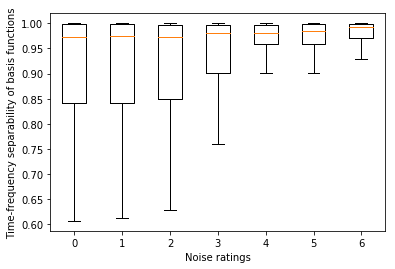

In [91]:
plt.boxplot([seps_stim_fg[i] for i in range(7)], labels=range(7), showfliers=False)
plt.xlabel('Noise ratings')
plt.ylabel('Time-frequency separability of basis functions')
plt.savefig('boxplots_ratings_separability.svg')

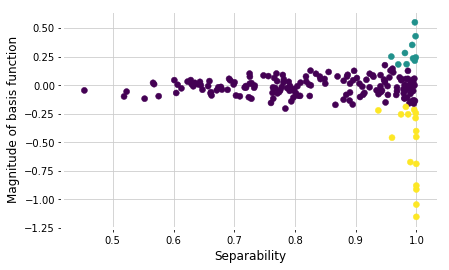

In [6]:
idxes = np.zeros_like(separability)
idxes[pos_sep_bool] = 1
idxes[neg_sep_bool] = 2
plt.scatter(separability, mean_Ws, c=idxes)
plt.xlabel('Separability')
plt.ylabel('Magnitude of basis function')
plt.savefig('separability_magnitude.svg')

In [6]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
pc_preds_db = linreg.fit(db[:,None], pcs).predict(db[:,None])
pc_res = pcs-pc_preds_db

Text(0,0.5,'Second component')

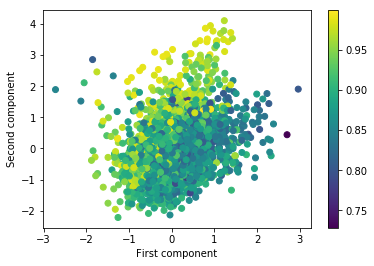

In [7]:
plt.scatter(pc_res[:,0], pc_res[:,1], c=sep_2)
#plt.scatter(pcs[ratings_idx][:,0], pcs[ratings_idx][:,1], c=mean_ratings, cmap='coolwarm')
plt.colorbar()
plt.xlabel('First component')
plt.ylabel('Second component')
#plt.savefig('pc12_mean_separability.png')

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2,1e2)) + WhiteKernel(noise_level=1e-10, noise_level_bounds=(1e-10,1e3))
gpr = GaussianProcessRegressor(kernel=kernel).fit(mean_ratings[:,None], pcs[:,0][ratings_idx])
X_ = np.linspace(np.min(mean_ratings), np.max(mean_ratings), 100)
y_mean, y_cov = gpr.predict(X_[:,None], return_cov=True)

In [32]:
import lowess as lo
space = np.linspace(mean_ratings.min()+0.3, mean_ratings.max(), 10)
fhat = lo.lowess(mean_ratings, pcs[:,2][ratings_idx], space)

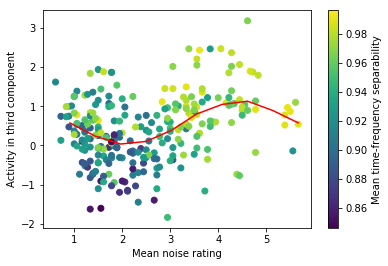

In [33]:
plt.scatter(mean_ratings, pcs[:,2][ratings_idx], c=sep_mean[ratings_idx])
plt.plot(space, fhat, 'r')
plt.xlabel('Mean noise rating')
plt.ylabel('Activity in third component')
cbar = plt.colorbar()
cbar.set_label('Mean time-frequency separability')
plt.savefig('pc_3_invariance_noise.svg')

/home/mboos/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/home/mboos/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


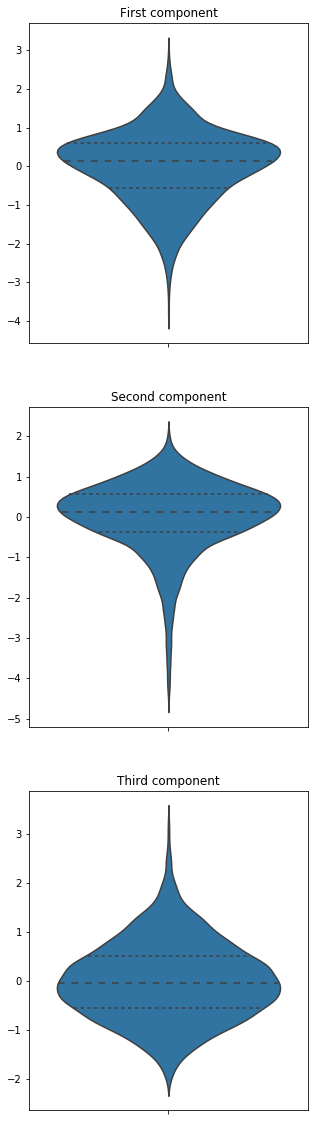

In [6]:
fig, axes = plt.subplots(3,1, figsize=(5,20))
for i, ax in enumerate(axes.flatten()):
    sns.violinplot(pcs[:,i], inner='quartiles', orient='v', ax=ax)
    ax.set_title('{} component'.format({0:'First',1:'Second',2:'Third'}[i]))
plt.savefig('Component_violinplots.svg')

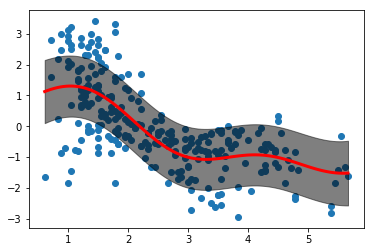

In [44]:
plt.scatter(mean_ratings, pcs[:,0][ratings_idx])
plt.plot(X_, y_mean, 'r', lw=3)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')

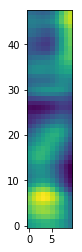

In [53]:
rec = reduce(lambda x,y : x+y, [Ws[i] for i in smpl])
plt.imshow(rec.T, origin='lower')

In [54]:
from sklearn.feature_selection import chi2, f_classif, f_regression
levels = [-10,5,0,5,10]
summed_bscs = [np.reshape(stims['SNR {} db'.format(lvl)], (-1,60,200)).sum(axis=1) for lvl in levels]
summed_bscs = np.vstack(summed_bscs)
mean_summed_bscs = np.reshape(summed_bscs, (4,-1,200)).mean(axis=1)
labels = np.repeat(levels, stims.values()[0].shape[0])
stats, pvals = chi2(summed_bscs, labels)
#stats, pvals = f_regression(summed_bscs, labels)
stats = np.abs(np.array([np.cov(smbsc, labels)[0,1] for smbsc in summed_bscs.T]))
stats = np.array(stats)
stats[np.isnan(stats)] = 0
#stats = entropies
sorted_stats = np.argsort(stats)

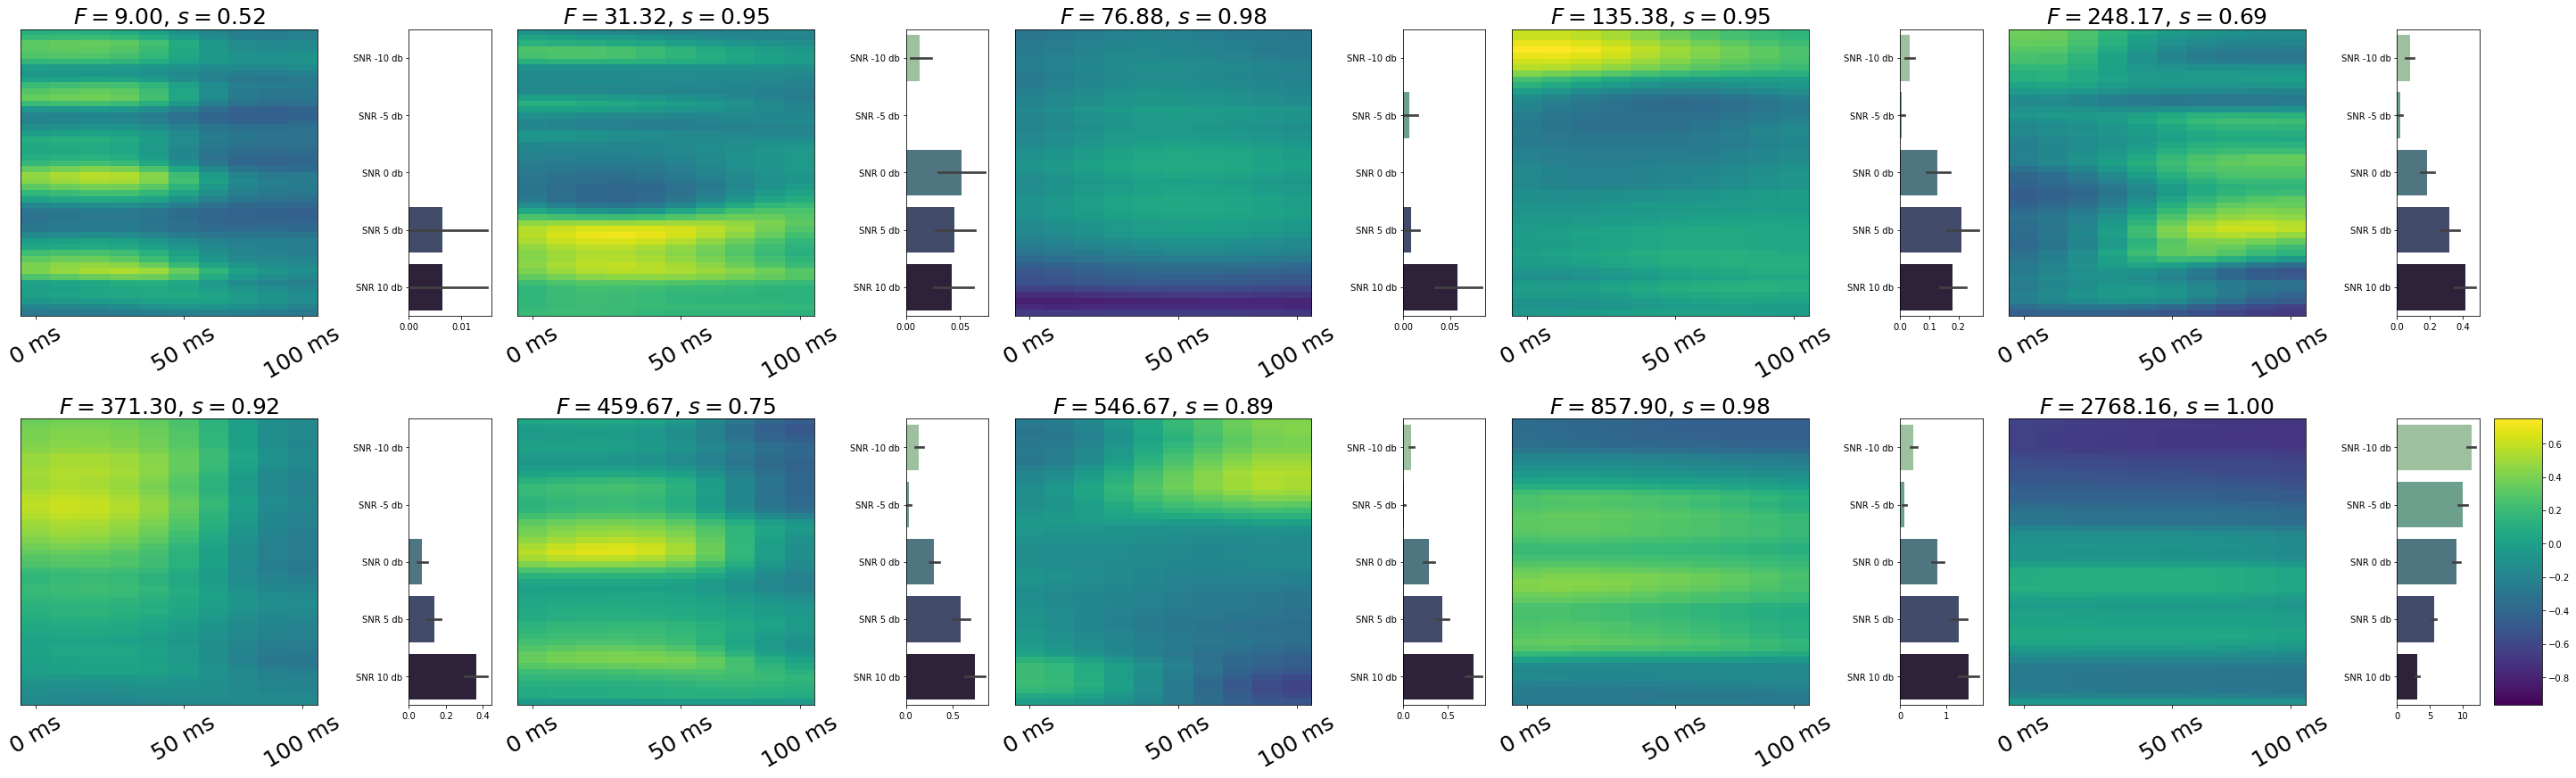

In [47]:
#smpl = np.where(np.reshape(bscs[sample_high_noise], (60, 200))[0])[0]
#smpl = np.where(babble_fg_bscs[0][0])[0]
import matplotlib as mpl
ratings_cmap = sns.cubehelix_palette(5, start=.5, light=.7, rot=-.75)
smpl = sorted_stats[[27,47,67,87,107,127,147,167,187,-2,-1]]
yspace = np.logspace(0, np.log10(8000), 48)
yticks = [2, 24, 47]
ytick_labels = ['1 Hz', '100 Hz', '8000 Hz']
xticks = [0, 5, 9]
xtick_labels = ['0 ms', '50 ms', '100 ms']
fig = plt.figure(figsize=(40,12), constrained_layout = True)
gs = mpl.gridspec.GridSpec(2, min(smpl.size,5)*3, figure=fig)
axes = np.concatenate([(fig.add_subplot(gs[int(i/5),((i%5)*3):((i%5)*3+2)]), fig.add_subplot(gs[int(i/5), ((i%5)*3+2):(((i%5)+1)*3)])) for i in range(10)])
maxes, mins = zip(*[(Ws[i].max(), Ws[i].min()) for i in smpl])
for i, ax in enumerate(np.reshape(axes,(-1,2))):
    im = ax[0].imshow(Ws[smpl[i]].T, origin='lower', aspect='auto', cmap='viridis', vmax=max(maxes), vmin=min(mins))
    ax[0].get_yaxis().set_visible(False)
    ax[0].get_xaxis().set_visible(True)
    ax[0].set_xticks(xticks)
    ax[0].set_xticklabels(xtick_labels)
    ax[0].tick_params(axis='x', which='major', labelsize=25, labelrotation=30)
#    ax.set_title(r'$Chi^{{2}}={0:.2f}$'.format(stats[smpl[i]]), {'fontsize':25})
    ax[0].set_title(r'$F={0:.2f}$, $s={1:.2f}$'.format(stats[smpl[i]], separability[smpl[i]]), {'fontsize':25})
    ax_bar = sns.barplot(data=[smbsc for smbsc in np.reshape(summed_bscs[:,smpl[i]], (len(levels),-1))], orient='h', ax=ax[1], palette=ratings_cmap)
    ax_bar.set_yticks([0,1,2,3,4])
    ax_bar.set_yticklabels(['SNR {} db'.format(i) for i in levels])
#    if i % 5 == 0:
#        ax.get_yaxis().set_visible(True)
#        ax.set_yticks(yticks)
#        ax.set_yticklabels(ytick_labels)
#        ax.tick_params(axis='y', which='major', labelsize=25)
plt.colorbar(im)
#plt.savefig('best_separating_basis_functions_f_reg_new.svg')

In [5]:
argsorted_ratings = np.argsort(mean_ratings)
import audio_mel_extraction as audme
sample_high_noise = ratings_idx[argsorted_ratings[-20]]
sample_medium_noise = ratings_idx[argsorted_ratings[-150]]
sample_low_noise = ratings_idx[argsorted_ratings[25]]
sample_low_noise = ratings_idx[argsorted_ratings[2]]
mfs_high_noise = audme.extract_mel('../sample_wavs/{}.wav'.format(sample_high_noise))
mfs_medium_noise = audme.extract_mel('../sample_wavs/{}.wav'.format(sample_medium_noise))
mfs_low_noise = audme.extract_mel('../sample_wavs/{}.wav'.format(sample_low_noise))
test_noise = audme.extract_mel('../noises/comb_cafe005_nl_20.wav')

In [6]:
all_bsc_mels = [audme.extract_mel('../sample_wavs/{}.wav'.format(i)) for i in range(3539)]

In [ ]:
all_bsc_mels

In [16]:
ratings_idx[argsorted_ratings[2]]

1996

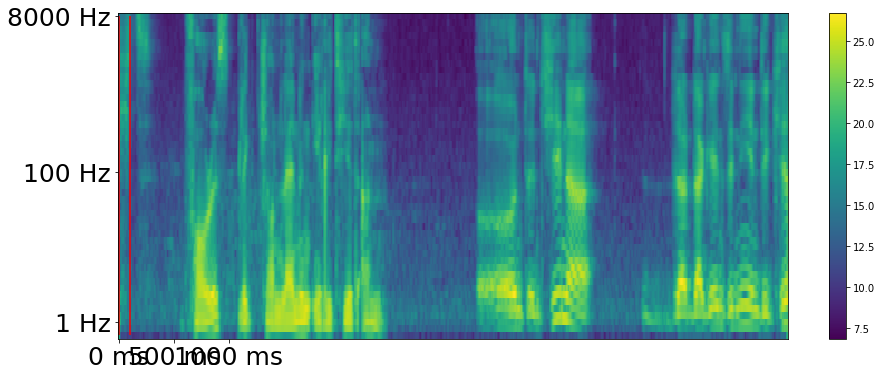

In [32]:
yspace = np.logspace(0, np.log10(8000), 48)
yticks = [2, 24, 47]
ytick_labels = ['1 Hz', '100 Hz', '8000 Hz']
xticks = [0, 50, 99]
xtick_labels = ['0 ms', '500 ms', '1000 ms']
fig, ax = plt.subplots(1,1,figsize=(15,6))
im = ax.imshow(np.log(mfs_low_noise).T, origin='lower', aspect='auto')
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.tick_params(axis='x', which='major', labelsize=25)
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.tick_params(axis='y', which='major', labelsize=25)
ax.vlines([0,10],0,47,colors='r')
plt.colorbar(im)

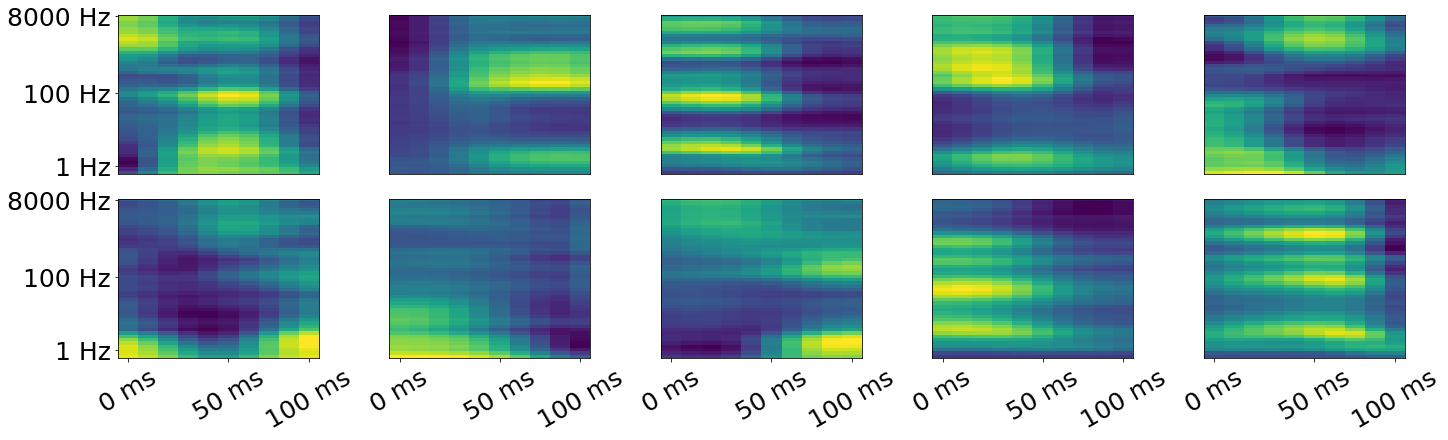

In [8]:
yspace = np.logspace(0, np.log10(8000), 48)
yticks = [2, 24, 47]
ytick_labels = ['1 Hz', '100 Hz', '8000 Hz']
xticks = [0, 5, 9]
xtick_labels = ['0 ms', '50 ms', '100 ms']
fig, axes = plt.subplots(2,5, figsize=(20,6), constrained_layout = True)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(Ws[args_sep[i]].T, origin='lower', aspect='auto', cmap='viridis')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
for ax in axes[-1,:]:
    ax.get_xaxis().set_visible(True)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.tick_params(axis='x', which='major', labelsize=25, labelrotation=30)
for ax in axes[:,0]:
    ax.get_yaxis().set_visible(True)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    ax.tick_params(axis='y', which='major', labelsize=25)
plt.savefig('least_separable_BF.png')

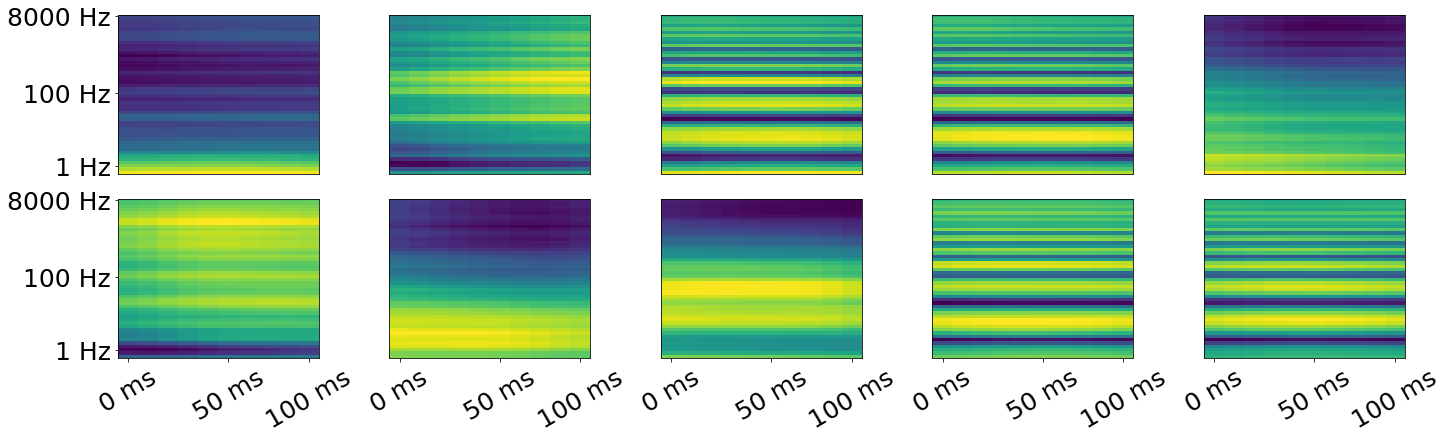

In [9]:
yspace = np.logspace(0, np.log10(8000), 48)
yticks = [2, 24, 47]
ytick_labels = ['1 Hz', '100 Hz', '8000 Hz']
xticks = [0, 5, 9]
xtick_labels = ['0 ms', '50 ms', '100 ms']
fig, axes = plt.subplots(2,5, figsize=(20,6), constrained_layout = True)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(Ws[args_sep[::-1][i]].T, origin='lower', aspect='auto', cmap='viridis')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
for ax in axes[-1,:]:
    ax.get_xaxis().set_visible(True)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.tick_params(axis='x', which='major', labelsize=25, labelrotation=30)
for ax in axes[:,0]:
    ax.get_yaxis().set_visible(True)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    ax.tick_params(axis='y', which='major', labelsize=25)
#fig.savefig('most_separable_BF.png')

In [60]:
from sklearn.cross_validation import cross_val_predict
from sklearn.linear_model import LinearRegression
preds = cross_val_predict(LinearRegression(), np.concatenate([bla[ratings_idx][:,None]], axis=-1), mean_ratings)

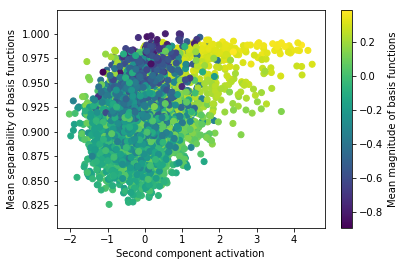

In [17]:
plt.scatter(pcs[:,1], sep_mean, c=average_W)
plt.xlabel('Second component activation')
plt.ylabel('Mean separability of basis functions')
cbar = plt.colorbar()
cbar.set_label('Mean magnitude of basis functions')
plt.savefig('pc2_separability_magnitude.png')

In [12]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(method='ltsa', n_neighbors=30, n_components=1, random_state=100).fit(pcs)
emb = lle.transform(pcs)

emb = lle.transform(pcs)
plt.scatter(pcs[:,0], pcs[:,1], c=np.squeeze(emb))
cbar = plt.colorbar()
cbar.set_label('1D-manifold value')
plt.xlabel('Third component')
plt.ylabel('Second component')
#plt.savefig('manifold_pcs_12.svg')
#plt.scatter(pcs[:,2], pcs[:,1], c=np.squeeze(emb))
#plt.colorbar()
#plt.savefig('manifold_pcs_32.svg')

counts, bins = np.histogram(emb, bins=5)
clusters = np.squeeze(np.digitize(emb, bins))-1

In [16]:
joblib.dump(clusters, 'new_clusters.pkl')

['new_clusters.pkl']

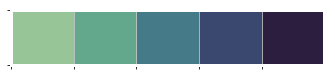

In [22]:
sns.palplot(sns.cubehelix_palette(5, start=.5, light=.7, rot=-.75))

In [26]:
speech = joblib.load('speech_overlap.pkl')
minlength = 1
minspeech_bool = speech>minlength

In [27]:
minspeech_bool.sum() / speech.shape[0]

0.9807855326363379

In [40]:
ratings_above_thresh = np.isin(ratings_idx,np.where(minspeech_bool)[0])
new_ratings_idx = ratings_idx[ratings_above_thresh]

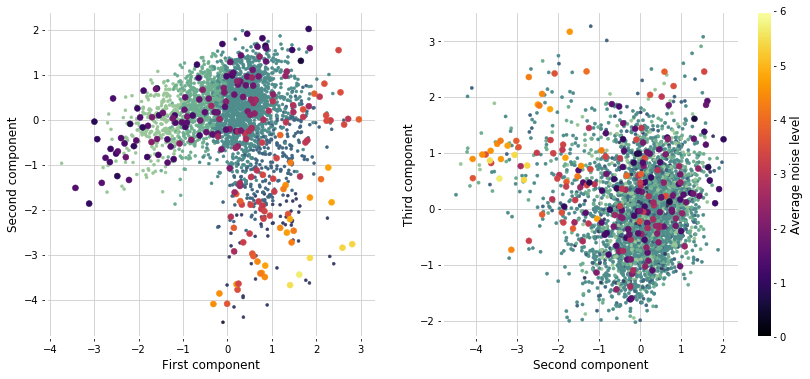

In [44]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from matplotlib.colorbar import make_axes
pallette = np.array(sns.cubehelix_palette(6, start=.5, light=.7, rot=-.75))
#gmm = GaussianMixture(n_components=4, init_params='random', max_iter=300, n_init=100)
#gmm = BayesianGaussianMixture(n_components=5, max_iter=500, n_init=20,
#                                        covariance_type='full')
#clusters = gmm.fit(pcs).predict(pcs)
#pallette = np.array(sns.color_palette('deep'))
fig, axes = plt.subplots(1,2, figsize=(14,6))
axes[0].scatter(pcs[:,0][minspeech_bool], pcs[:,1][minspeech_bool], c=pallette[clusters[minspeech_bool]], s=35, marker='.')
axes[0].scatter(pcs[new_ratings_idx][:,0], pcs[new_ratings_idx][:,1], vmin=0., vmax=6., c=mean_ratings[ratings_above_thresh], cmap='inferno')
axes[0].set_xlabel('First component')
axes[0].set_ylabel('Second component')
axes[1].scatter(pcs[:,1], pcs[:,2], c=pallette[clusters[minspeech_bool]], s=10)
mappable = axes[1].scatter(pcs[new_ratings_idx][:,1], pcs[new_ratings_idx][:,2], s=35, vmin=0., vmax=6., c=mean_ratings[ratings_above_thresh], cmap='inferno')
axes[1].set_xlabel('Second component')
axes[1].set_ylabel('Third component')
fig.subplots_adjust(right=0.8)
cax,_ = make_axes(axes[1], fraction=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label('Average noise level')
plt.savefig('pcs_latent_space_above_5s.svg')

In [7]:
speech = joblib.load('speech_overlap.pkl')

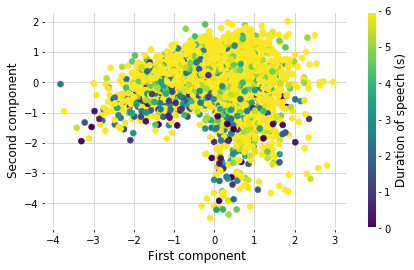

In [11]:
mappable = plt.scatter(pcs[:,0], pcs[:,1], c=speech)
cbar= plt.colorbar(mappable)
cbar.set_label('Duration of speech (s)')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.savefig('pcs_speech.png', dpi=300)

In [92]:
sep_mean_no_bn[np.isnan(sep_mean_no_bn)] = np.nanmean(sep_mean_no_bn)

In [113]:
full_ds = np.concatenate([pcs, speech[:,None], db[:,None], sep_mean[:,None]], axis=1)

In [116]:
noise_ds = np.concatenate([full_ds[ratings_idx], mean_ratings[:,None]], axis=1)
joblib.dump(noise_ds, 'ds_noise.pkl')

['ds_noise.pkl']

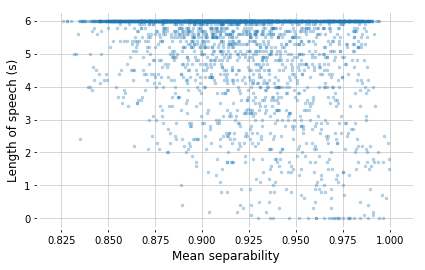

In [20]:
bla = plt.scatter(sep_mean, speech, s=35, marker='.', alpha=0.3)
plt.xlabel('Mean separability')
plt.ylabel('Length of speech (s)')
#plt.colorbar(mappable=bla)
plt.savefig('separability_speechlength.svg')

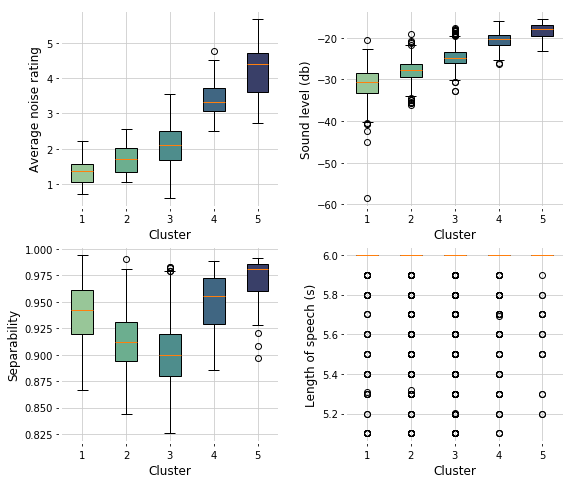

In [55]:
data_dict = {'Separability' : [sep_mean[minspeech_bool][clusters[minspeech_bool]==i] for i in range(5)],
             'Average noise rating' : [mean_ratings[ratings_above_thresh][clusters[new_ratings_idx]==i] for i in range(5)],
             'Length of speech (s)' : [speech[minspeech_bool][clusters[minspeech_bool]==i] for i in range(5)],
             'Sound level (db)' : [db[minspeech_bool][clusters[minspeech_bool]==i] for i in range(5)]}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 6))
ft_order = ['Average noise rating', 'Sound level (db)', 'Separability', 'Length of speech (s)']
for ft, ax in zip(ft_order, axes.flatten()):
    # rectangular box plot
    prop = data_dict[ft]
    bplot = ax.boxplot(prop,
                             vert=True,   # vertical box aligmnent
                             patch_artist=True)   # fill with color

    for patch, color in zip(bplot['boxes'], pallette):
        patch.set_facecolor(color)

    ax.set_ylabel(ft)
    ax.set_xlabel('Cluster')
plt.subplots_adjust(top=1., bottom=0., left=0., right=1., wspace=0.3)
plt.savefig('marginalised_length_cluster_descriptions.svg')

In [15]:
from scipy.stats import ttest_ind
data = [sep_mean[clusters==i] for i in range(2)]
print(ttest_ind(data[0], data[1]))

Ttest_indResult(statistic=-23.813412501010127, pvalue=2.217198980207807e-116)


In [24]:
import statsmodels.api as sm
X = pd.DataFrame({'Decibel' : db[ratings_idx], 'Mean time-frequency separability' : sep_mean[ratings_idx]})
X = sm.add_constant(X)
model = sm.OLS(mean_ratings, X, missing='drop').fit()
model.endog_names = ['Mean perceived noise level']
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                   &        y         & \textbf{  R-squared:         } &     0.689   \\
\textbf{Model:}                           &       OLS        & \textbf{  Adj. R-squared:    } &     0.686   \\
\textbf{Method:}                          &  Least Squares   & \textbf{  F-statistic:       } &     287.6   \\
\textbf{Date:}                            & Wed, 25 Jul 2018 & \textbf{  Prob (F-statistic):} &  1.31e-66   \\
\textbf{Time:}                            &     10:47:02     & \textbf{  Log-Likelihood:    } &   -265.82   \\
\textbf{No. Observations:}                &         263      & \textbf{  AIC:               } &     537.6   \\
\textbf{Df Residuals:}                    &         260      & \textbf{  BIC:               } &     548.4   \\
\textbf{Df Model:}                        &           2      & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
               

In [5]:
from scipy.stats import pearsonr
pearsonr(db[ratings_idx], mean_ratings)

(0.7519253817012481, 3.868561539229273e-49)

In [21]:
from sklearn.linear_model import HuberRegressor
r2_dict = {mdl : HuberRegressor().fit(dat[ratings_idx][:,None], mean_ratings).score(dat[ratings_idx][:,None], mean_ratings) for mdl, dat in [('db', db), ('separability', sep_2), ('mean activation', bla)]}

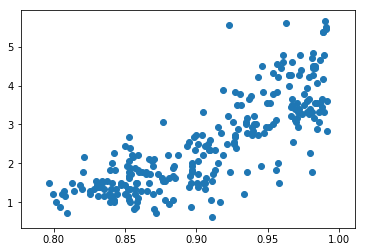

In [36]:
plt.scatter(sep_2[ratings_idx], mean_ratings)

In [51]:
pred_dict2 = joblib.load('preds_db.pkl')
pred_dict2 = {key : np.concatenate([val[None] for val in vals], axis=0) for key, vals in pred_dict2.items()}
flips = joblib.load('flips.pkl')
pred_dict_flipped = {key : np.concatenate([flips[pc].dot(vals[:,:,pc])[...,None] for pc in range(3)],axis=-1) for key, vals in pred_dict2.items()}

In [95]:
from sklearn.linear_model import LinearRegression
bsc_preds = joblib.load('pc_red_coef_preds.pkl')
mean_preds = bsc_preds.mean(axis=0)[:,:3]
linreg = LinearRegression()
linreg.fit(mean_preds[ratings_idx], mean_ratings)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [102]:
noise_preds = {key : linreg.predict(val.mean(axis=0)) for key, val in pred_dict_flipped.items()}
ordreg_df = pd.DataFrame({'Predicted noise' : np.concatenate([noise_preds[i] for i in [-10,-5,0,5,10]]), 'Speech SNR':np.concatenate([['{} db'.format(i)]*noise_preds.values()[0].shape[0] for i in [-10,-5,0,5,10]])})

In [108]:
pred_dict_flipped[0].shape

(15, 468, 3)

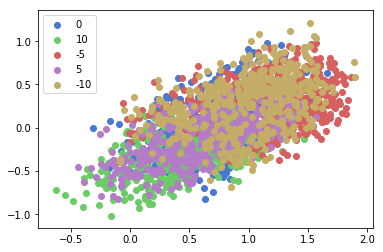

In [109]:
fig, ax = plt.subplots(1,1)
for c, (key, val) in zip(sns.color_palette('muted')[:5],pred_dict_flipped.items()):
    ax.scatter(val.mean(axis=0)[:,0], val.mean(axis=0)[:,1], c=c, label=key)
plt.legend()

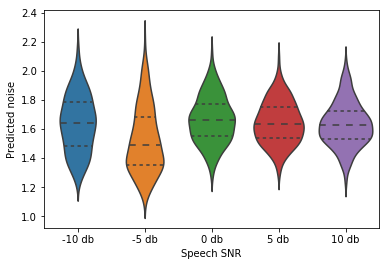

In [103]:
#sns.violinplot([ordreg_dict['speech_{}db_snr'.format(i)] for i in [0,5,10,15]])
fig, ax = plt.subplots(1,1)
sns.violinplot(data=ordreg_df, x='Speech SNR', y='Predicted noise', ax=ax, inner='quartiles')
#plt.boxplot([ordreg_dict['speech_{}db_snr'.format(i)] for i in [0,5,10,15]])
#sns.pointplot(data=ordreg_df, x='Speech SNR', y='Predicted noise', color='black')
#plt.savefig('corpus_generalization.svg')